

# Modeling Rainfall with the $\gamma$ distribution

Let's practice what we learned. Let's build a **Bayesian model** for a dataset, so we can extract precise statistics from the model itself, rather than the data. 

You may use `PyMC3` or `Sampyl` for this homework.

### How to build a Bayesian model?
* Look at the histogram of the data
* Pick an analytic probability densiy function matching the shape of the histogram
* Model its parameters (priors) as probability density functions
* Try different shape and values of these parameters (these are called *hyperparameters*)
* Run a probabilistic program to give us the posterior pdfs
* Plot the posterior means on top of the histogram and check if we get a good match!

We will model rainfall data per calendar month for the city of Nashville, Tennessee. Rainfall data is usually modelled with  the $\gamma$ distribution. 

<br />
<center>
<img src="ipynb.images/rainfall.jpeg" width=400 />
</center>

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## 1. The $\gamma$ distribution

This is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution):

<div style="font-size: 120%;">  
$$\gamma(x) = \frac{\beta^\alpha x^{\alpha -1} e^{- \beta x}}{\Gamma (\alpha)}$$
</div>

How many parameters in the gamma function?

What is the $\Gamma()$ function? It [interpolates](https://en.wikipedia.org/wiki/Gamma_function) the factorial function to non-integer values!

This is what the $\gamma$ function for $x > 0$ and $\alpha, \beta > 0$ looks like:

</br >
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg" width="500" />
Gamma distribution
</center>

## 2. Dataset: Nashville Precipitation

The dataset `nashville_precip.txt` contains NOAA precipitation data for Nashville measured since 1871. Download it from blackboard and put it in the right folder (`C:/Users/<username>/data`). 
    
The $\gamma$ distribution happens to be a good fit to aggregated rainfall data, and will be our candidate model in this case. 

Let's peek at the data:

In [4]:
precip = pd.read_table("/Users/cnakhare/Desktop/DataScience/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


Let's do some data exploration..

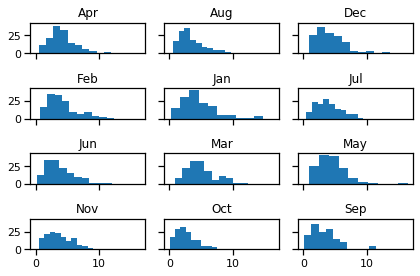

In [5]:
a = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is recognizing what sort of distribution to fit our data to. A couple of observations:

1. The data is *skewed*, with a longer tail to the right than to the left
2. The data is *positive-valued*, since they are measuring rainfall
3. The data is *continuous*

There are a few possible choices, but a good option is the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). If $x$ measures rainfall:

<div style="font-size: 120%;">  
$$x \sim \gamma(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

The gamma distribution is often used to model the size of [insurance claims](https://www.crcpress.com/Statistical-and-Probabilistic-Methods-in-Actuarial-Science/Boland/p/book/9781584886952) and [rainfalls](http://journals.tubitak.gov.tr/engineering/issues/muh-00-24-6/muh-24-6-7-9909-13.pdf). This means that aggregate insurance claims and the amount of rainfall accumulated in a reservoir are usually well modelled by a gamma process.


## 3. Data Cleansing 

Wait a sec.. There's something wrong with our data.. if you open it in a text editor, you will find a value of NA for October of 1963 (take a look!). So we have to do some data cleansing first (remember the first step in data science from Lecture 1?). Given what we are trying to do, it is sensible to fill in the missing value with the **average of the available values** (another option would have been the average of the months of September and November 1963).


In [6]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,3.32,1.84,2.26,2.75,3.30,2.37,1.47,1.38,1.99,4.95,6.20,3.83
2008,4.76,2.53,5.56,7.20,5.54,2.21,4.32,1.67,0.88,5.03,1.75,6.72
2009,4.59,2.85,2.92,4.13,8.45,4.53,6.03,2.14,11.08,6.49,0.67,3.99


## 4. Exploration

Let's calculate the **means** and **variances** of precipitation, month by month:

In [7]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [8]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [9]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

Ok, now comes the most complicated part of Bayesian estimation: Let's pick pdfs for the $\gamma$ distribution's parameters $\alpha$ and $\beta$. We're taking numbers, and modeling them as distributions, so that we can take a probabilistic program to figure out the best values for these parameters. If you understand this, then you understand the most complicated part of Bayesian estimation theory!

Let's firt try to model rainfall for the month of April, only.


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


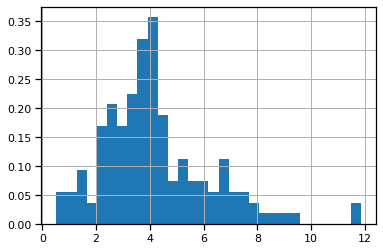

In [10]:
precip.Apr.hist(normed=True, bins=30)

In [12]:

from pymc3 import Model, Uniform, Gamma

In [13]:
with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)
with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [14]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
print(rainfall_trace)

Finished [100%]: Average Loss = 366.52


<MultiTrace: 1 chains, 1000 iterations, 4 variables>


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


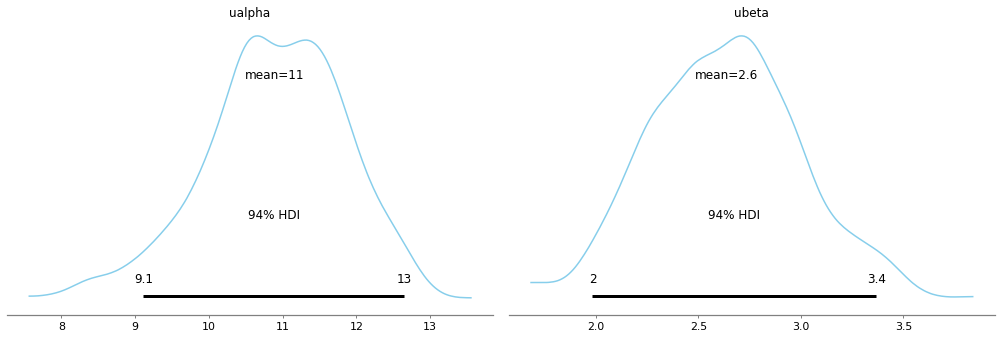

In [15]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

Are my hyperparameters not the right choice? Try different ones and improve on my model for extra credit.

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


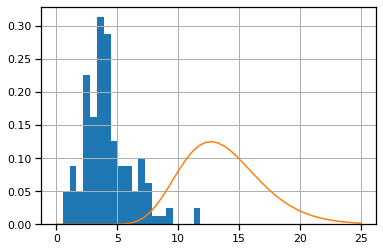

In [16]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 11
ubeta_posterior_mean = 2.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))



Did the Uniform distribution work out well in your modeling exercise above? Well, it didn't for professor!

Let's try the `Normal` distribution instead. Please make sure to introduce **new** variables for your priors (xxxalpha, xxxbeta), as well as your simulation trace (xxxapril_like). Replace xxx with whatever you want.

What's the right support for the normal (the right mean and standard deviation)? Pick a mean that centers the gaussian around the peak of the month, and a standard deviation that allows the gaussian to cover all the data.

In [17]:
from pymc3 import Normal

In [18]:
mean_normal=precip.Apr.mean()

In [19]:
var_normal=precip.Apr.var()

In [20]:
with Model() as rainfall_model:
    nalpha = Normal('nalpha', mu=mean_normal, sigma=var_normal, tau=None, sd=
None)
    nbeta = Normal('nbeta', mu=mean_normal, sigma=var_normal, tau=None, sd=
None)

In [21]:
with rainfall_model:
    april_like_normal = Gamma('april_like_normal', alpha=nalpha, beta=nbeta, observed=precip.Apr)

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:103: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:103: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [22]:

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
print(rainfall_trace)

Finished [100%]: Average Loss = 329.52


<MultiTrace: 1 chains, 1000 iterations, 2 variables>


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


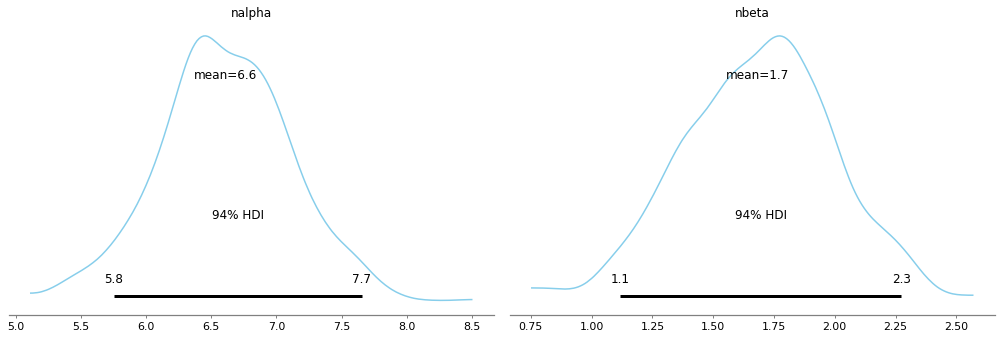

In [23]:

plot_posterior(rainfall_trace[100:], 
                varnames=['nalpha', 'nbeta'],
                color='#87ceeb');

In [24]:
precip.Apr.mean()

4.204468085106384

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


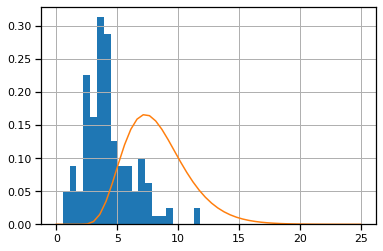

In [25]:

nalpha_posterior_mean = 6.6
nbeta_posterior_mean = 1.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), nalpha_posterior_mean, nbeta_posterior_mean))



Let's try to accelerate things and try the exponential distribution, instead. Find the right number $x$ so that the distribution covers the range of possible precipitation values.  In other words, find the right value $y$ such that `Exponential.dist(1/3).random(size=10000)` covers from 0 to 12 for the month of April.


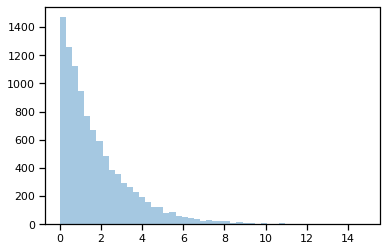

In [26]:
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/1.8).random(size=10000), kde=False);

In [27]:

with Model() as rainfall_model:
    ealpha = Exponential('ealpha', lam=2/5)
    ebeta = Exponential('ebeta', lam=2/5)

In [28]:
with rainfall_model:
    april_like_exp = Gamma('april_like_exp', alpha=ealpha, beta=ebeta, observed=precip.Apr)

In [29]:
with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
print(rainfall_trace)

Finished [100%]: Average Loss = 316.42


<MultiTrace: 1 chains, 1000 iterations, 4 variables>


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


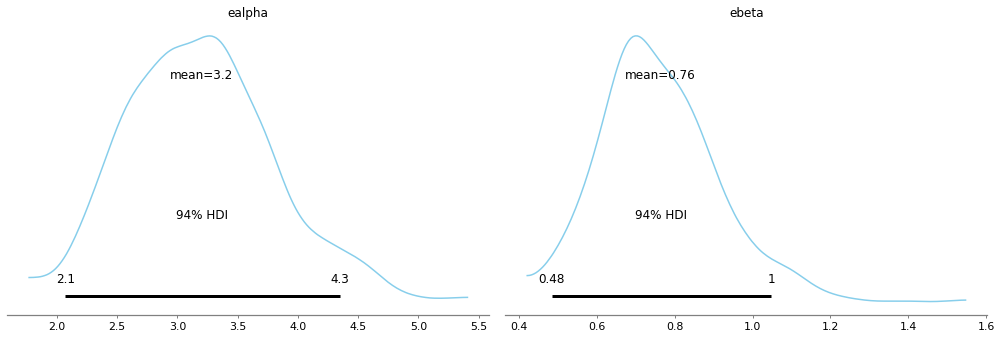

In [30]:
plot_posterior(rainfall_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


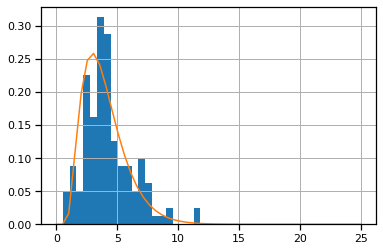

In [31]:
ealpha_posterior_mean = 3.2
ebeta_posterior_mean = 0.76

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ealpha_posterior_mean, ebeta_posterior_mean))

 month of January.

In [32]:
mean_normal_jan=precip.Jan.mean()
var_normal_jan= precip.Jan.var()

In [33]:
with Model() as rainfall_model:
    jan_alpha = Normal('jan_alpha', mu=mean_normal_jan, sigma=var_normal_jan, tau=None, sd=
None)
    jan_beta = Normal('jan_beta', mu=mean_normal_jan, sigma=var_normal_jan, tau=None, sd=
None)

In [34]:
with rainfall_model:
    jan_like = Gamma('jan_like', alpha=jan_alpha, beta=jan_beta, observed=precip.Jan)

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:103: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:103: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [35]:
with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
print(rainfall_trace)

Finished [100%]: Average Loss = 394.19


<MultiTrace: 1 chains, 1000 iterations, 2 variables>


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


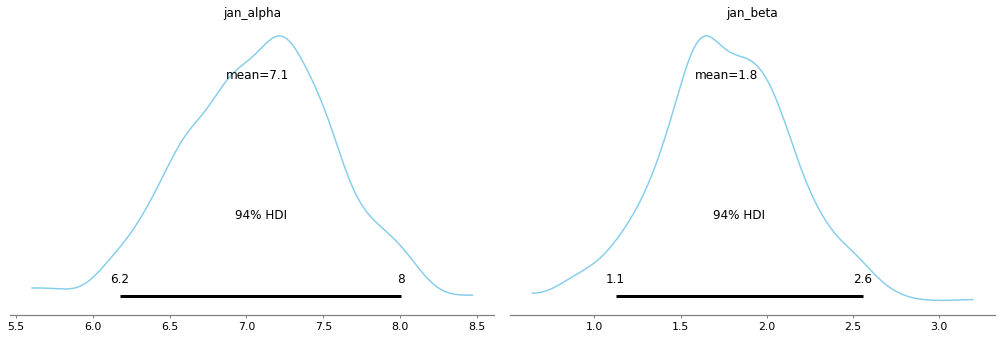

In [36]:
plot_posterior(rainfall_trace[100:], 
                varnames=['jan_alpha', 'jan_beta'],
                color='#87ceeb');

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


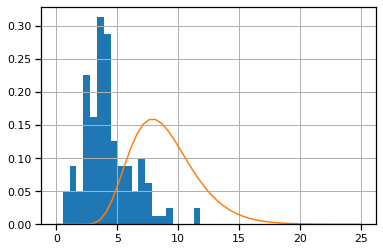

In [37]:
jan_alpha_posterior_mean = 7.1
jan_beta_posterior_mean = 1.8

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), jan_alpha_posterior_mean, jan_beta_posterior_mean))

In [38]:
min_jan = min(precip.Jan)
max_jan = max(precip.Jan)

with Model() as rainfall_model:
    ualpha_jan = Uniform('ualpha_jan', lower=0, upper=max_jan)
    ubeta_jan = Uniform('ubeta_jan', lower=0, upper=max_jan)

with rainfall_model:
    jan_like = Gamma('jan_like', alpha=ualpha_jan, beta=ubeta_jan, observed=precip.Jan)

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
    

Finished [100%]: Average Loss = 432.33


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


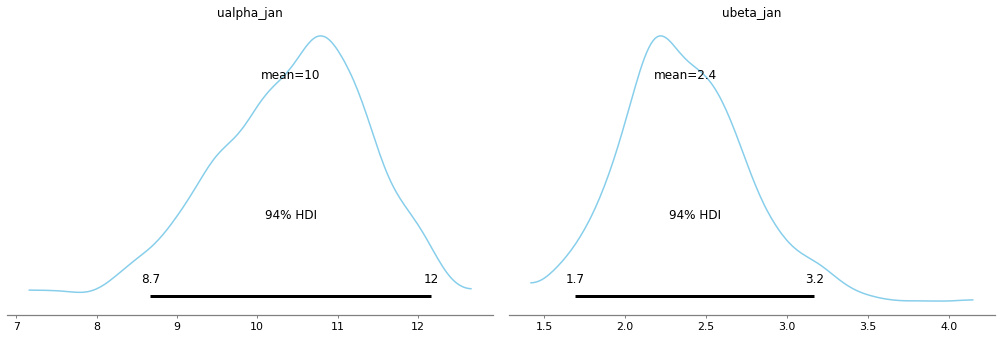

In [39]:

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha_jan', 'ubeta_jan'],
                color='#87ceeb');

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


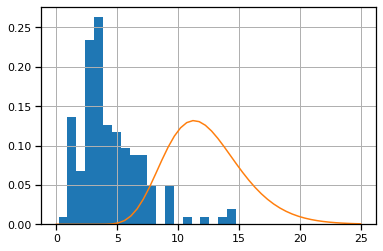

In [40]:
jan_ualpha_posterior_mean = 10
jan_ubeta_posterior_mean = 2.3

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), jan_ualpha_posterior_mean, jan_ubeta_posterior_mean))

In [41]:
with Model() as rainfall_model:
    ealpha_jan = Exponential('ealpha_jan', 2/5 )
    ebeta_jan = Exponential('ebeta_jan',2/5)

with rainfall_model:
    jan_like_exp = Gamma('jan_like_exp', alpha=ealpha_jan, beta=ebeta_jan, observed=precip.Jan)
with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)



Finished [100%]: Average Loss = 339.05


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


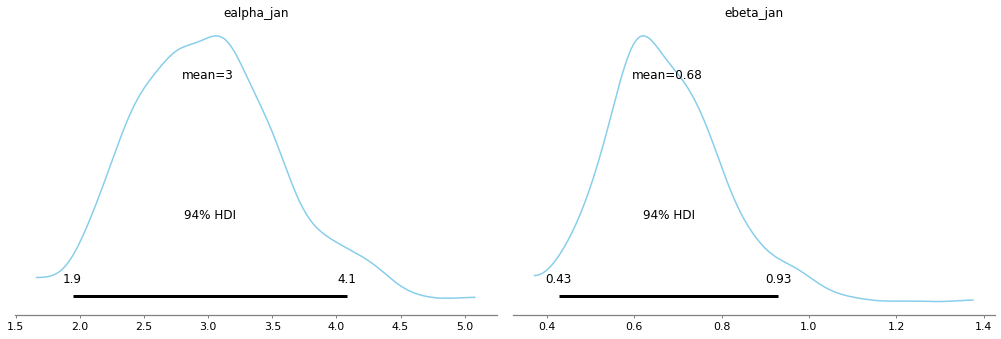

In [42]:

plot_posterior(rainfall_trace[100:], 
                varnames=['ealpha_jan', 'ebeta_jan'],
                color='#87ceeb');

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


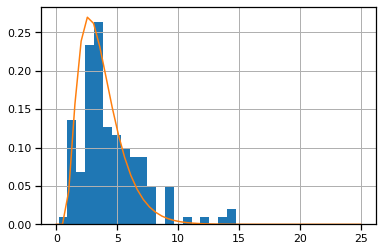

In [43]:
jan_ealpha_posterior_mean = 3
jan_ebeta_posterior_mean = 0.67

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), jan_ealpha_posterior_mean, jan_ebeta_posterior_mean))

### (Deep thought) Exercise 5:

How would you model *all* months together (*one* model, *all* months)? Is that even possible?

## 
Solving using Exponential for modelling all the months together:

In [44]:
from pymc3 import Model, Exponential,Gamma


with Model() as rainfall_model:
    ealpha = Exponential('ealpha',0.40) ## lambda calculated based on mean of the april month
    ebeta = Exponential('ebeta',0.40)
    
with rainfall_model:
    Exponential_like = Gamma('exponential_like', alpha=ealpha, beta=ebeta, observed=precip)

In [45]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 3,817.7


/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


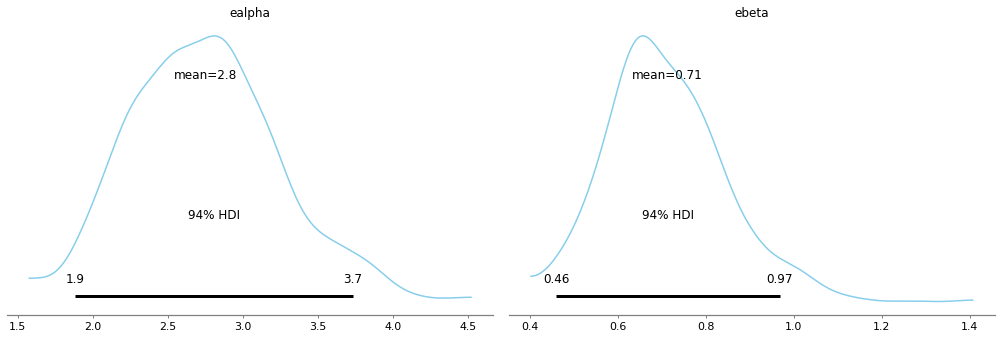

In [46]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ealpha', 'ebeta'],
                color='#87ceeb');

/Users/cnakhare/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:404: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


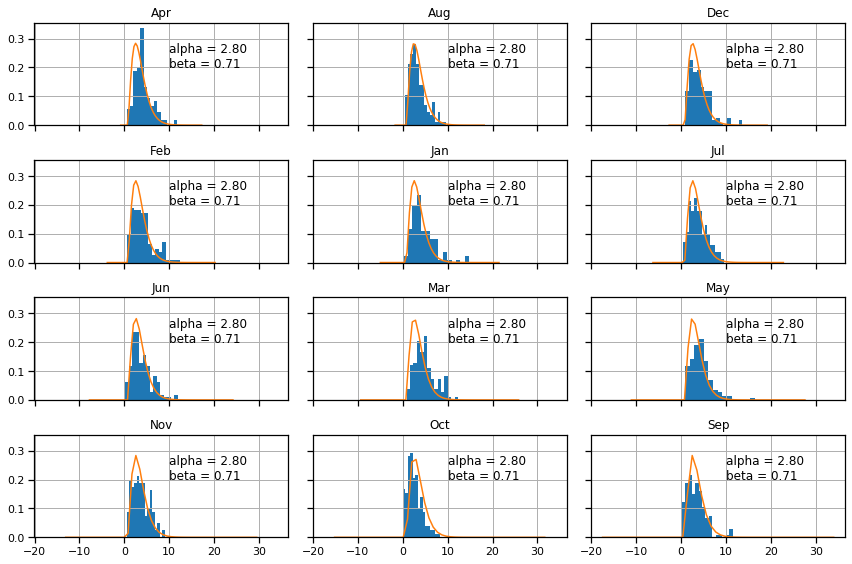

In [47]:
from scipy.stats.distributions import gamma
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

#using for loop to display all the month plot
for ax in axs.ravel():

    # Get month
    m = ax.get_title()

    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x,2.8,0.71))
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(2.8, 0.71)
    ax.annotate(label, xy=(10, 0.2))

plt.tight_layout()